# Convolutional Neural Networks: MNIST

In this notebook, you will:

- Implement helper functions that you will use when implementing a TensorFlow model
- Implement a fully functioning ConvNet using TensorFlow 

**After this assignment you will be able to:**

- Build and train a ConvNet in TensorFlow for a classification problem 

We assume here that you are already familiar with TensorFlow. 

## 1.0 - TensorFlow model

Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

We will start by loading in the packages. 

The MNIST Dataset is located at http://yann.lecun.com/exdb/mnist/. Each image has $28 \times 28$ dimension.

-train-images-idx3-ubyte.gz:  training set images (9912422 bytes) including 55000 examples <br>
-train-labels-idx1-ubyte.gz:  training set labels (28881 bytes) <br>
-t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes) including 10000 examples <br>
-t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [1]:
import math
import numpy as np
#import h5py
import matplotlib.pyplot as plt
#import scipy
#from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
number of training examples = 55000
number of test examples = 10000
X_train shape: (55000, 28, 28, 1)
Y_train shape: (55000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


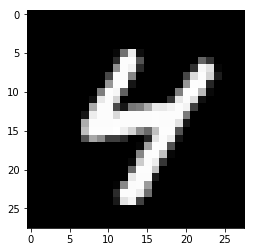

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X_train = np.vstack([img.reshape(-1,28,28,1) for img in mnist.train.images])
Y_train = mnist.train.labels
X_test = np.vstack([img.reshape(-1,28,28,1) for img in mnist.test.images])
Y_test = mnist.test.labels


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

index = 101
plt.imshow(X_train[index].reshape(28,28), cmap='gray')
print(Y_train[index])
del mnist

Previously, you had built a fully-connected network. But since this is an image dataset, it is more natural to apply a ConvNet to it.

Here is the model we build.

<table>
<td>
<img src="images/cnn.jpg" style="width:250;height:300px;">
</td>
</table>


### 1.1 - Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

**Exercise**: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension **[None, n_H0, n_W0, n_C0]** and Y should be of dimension **[None, n_y]**.  [Hint](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [7]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float32"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float32"
    """

    ### START CODE HERE ### (≈2 lines)
    ### Use "tf.placeholder()" with type=tf.float32 and name="X"
    X = tf.placeholder(tf.float32, shape=(None,n_H0, n_W0, n_C0),name="X")
    ### Use "tf.placeholder()" with type=tf.float32 and name="Y"
    Y = tf.placeholder(tf.float32, shape=(None,n_y),name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [8]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


**Expected Output**

<table> 
<tr>
<td>
    X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)

</td>
</tr>
<tr>
<td>
    Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)

</td>
</tr>
</table>

### 1.2 - Initialize parameters

You will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. Note that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. 

**Exercise:** Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter $W$ of shape [1,2,3,4] in Tensorflow, use:
```python
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```
[More Info](https://www.tensorflow.org/api_docs/python/tf/get_variable).

In [9]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        Wx : [filter_height, filter_width, in_channels, out_channels]
                        W1 : [5, 5, 1, 32]
                        W2 : [5, 5, 32, 64]
                        B1 : [32]
                        B2 : [64]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    # use tf.contrib.layers.xavier_initializer(seed=0) for Wx
    # use tf.random_normal_initializer(seed=0) for Bx
    # names for W1, W2, B1, B2 are "W1", "W2", "B1", "B2"
    W1 = tf.get_variable("W1", [5, 5, 1, 32], initializer =tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 32, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    B1 = tf.get_variable("B1", [32], initializer = tf.random_normal_initializer(seed=0))
    B2 = tf.get_variable("B2", [64], initializer = tf.random_normal_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                  "B1": B1,
                  "B2": B2}
    
    return parameters

In [10]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,0]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,0]))

Instructions for updating:
Colocations handled automatically by placer.
W1 = [-0.05074088  0.00199553  0.00414077 -0.04069575 -0.04086844  0.00398856
  0.07175875  0.023808   -0.02326647  0.04586978 -0.08235063  0.00816405
 -0.0385248  -0.02892781  0.00744654  0.07795027 -0.05518249  0.05105729
 -0.05234016  0.04300165 -0.04925928  0.0612269  -0.03208476 -0.05321277
  0.07479723 -0.06783506 -0.05706007 -0.07336373  0.03016851  0.00548052
 -0.04078463 -0.06712879]
W2 = [-0.03979962 -0.01044408  0.00160269  0.00974461 -0.00254961 -0.03201561
  0.01373079 -0.01104505 -0.00841881 -0.0405      0.01020548 -0.03208991
 -0.00377375  0.00840064 -0.02394277 -0.00931381 -0.02332927  0.00155168
  0.04541015 -0.03421994 -0.03484461  0.03370252 -0.03387171  0.03562606
  0.02762317 -0.0401171  -0.01749424 -0.01980509 -0.01918935 -0.03243086
 -0.03648937  0.02757055  0.04312921  0.03236486 -0.01132439  0.04101669
 -0.02529923 -0.03054604 -0.04599814  0.02845765  0.03051175  0.03806292
  0.03111282  0.

** Expected Output:**

<table> 
    <tr>
        <td>
        W1 = 
        </td>
        <td>
[-0.05074088  0.00199553  0.00414077 -0.04069575 -0.04086844  0.00398856 <br>
  0.07175875  0.023808   -0.02326647  0.04586978 -0.08235063  0.00816405 <br>
 -0.0385248  -0.02892781  0.00744654  0.07795027 -0.05518249  0.05105729 <br>
 -0.05234016  0.04300165 -0.04925928  0.0612269  -0.03208476 -0.05321277 <br>
  0.07479723 -0.06783506 -0.05706007 -0.07336373  0.03016851  0.00548052 <br>
 -0.04078463 -0.06712879]
        </td>
    </tr>
    <tr>
        <td>
        W2 = 
        </td>
        <td>
[-0.03979962 -0.01044408  0.00160269  0.00974461 -0.00254961 -0.03201561 <br>
  0.01373079 -0.01104505 -0.00841881 -0.0405      0.01020548 -0.03208991 <br>
 -0.00377375  0.00840064 -0.02394277 -0.00931381 -0.02332927  0.00155168 <br>
  0.04541015 -0.03421994 -0.03484461  0.03370252 -0.03387171  0.03562606 <br>
  0.02762317 -0.0401171  -0.01749424 -0.01980509 -0.01918935 -0.03243086 <br>
 -0.03648937  0.02757055  0.04312921  0.03236486 -0.01132439  0.04101669 <br>
 -0.02529923 -0.03054604 -0.04599814  0.02845765  0.03051175  0.03806292 <br>
  0.03111282  0.01980932  0.03713584 -0.01831943  0.02628484  0.04115831 <br>
 -0.00318412  0.00770112 -0.01159302  0.01928938  0.02738483  0.03404368 <br>
 -0.01715547 -0.04512585 -0.00854967  0.02034478 -0.00865594  0.02739711 <br>
  0.00798912 -0.03626674 -0.03301056  0.03195414]
        </td>
    </tr>

</table>

### 1.2 - Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.bias_add(value, bias, ...):** adds bias to value. [here](https://www.tensorflow.org/api_docs/python/tf/nn/bias_add)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)


**마지막에 activation fuction은 없다**

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


In the function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


**Exercise**: 

Implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. You should use the functions above. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 

In [23]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    B1 = parameters['B1']
    B2 = parameters['B2']
    
    ### START CODE HERE ###
    # CONV2D: filter W1, stride 1, padding 'SAME', use tf.nn.conv2d()
    # Add bias B1 with tf.nn.bias_add()
    # Z1's shape : (m, 28, 28, 32), 
    Z1 = tf.nn.conv2d(X,W1,strides = [1, 1, 1, 1], padding = 'SAME')
    Z1 = tf.nn.bias_add(Z1, B1)
    # RELU for Z1, use tf.nn.relu()
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: filter 2x2, sride 2, padding 'SAME', use tf.nn.max_pool()
    # P1's shape : (?, 14, 14, 32)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME', use.tf.nn.conv2d()
    # Add bias B2 with tf.nn.bias_add()
    # Z2's shape : (?, 14, 14, 64)
    Z2 =tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    Z2 = tf.nn.bias_add(Z2, B2)
    # RELU for Z2, use tf.nn.relu()
    A2 =  tf.nn.relu(Z2)
    # MAXPOOL: filter 2x2, stride 2, padding 'SAME', use tf.nn.max_pool()
    # P2's shape : (?, 7, 7, 64)
    P2 =  tf.nn.max_pool(A2, ksize =[1, 2, 2, 1],strides = [1,2,2,1],padding = 'SAME')

    # FLATTEN, use tf.contrib.layers.flatten()
    # P2's shape : (m, 3136)
    P2 = tf.contrib.layers.flatten(P2) 
    
    # fully connected layer. #node=1024, act=relu, use tf.contrib.layers.fully_connected()
    # Z3's shape : (?, 1024)
    Z3 = tf.contrib.layers.fully_connected(P2, 1024)

    # fully connected layer, #node=10, act=None, initialize with  tf.contrib.layers.xavier_initializer()
    # use tf.layers.dense()
    logits = tf.layers.dense(Z3,10,kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    ### END CODE HERE ###

    return logits

In [24]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(28, 28, 1, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,28, 28, 1), Y: np.random.randn(2,10)})
    print("Z3 = " + str(a))

Z3 = [[ 1.6433667   0.09301567 -0.41446364  0.19318342 -1.4254816   0.63224626
   1.1689535  -1.9044924   2.3826356  -0.7146049 ]
 [ 1.7232742  -0.04298186 -0.42503527  0.16844702 -1.3598577   0.61141723
   1.1773576  -1.9650702   2.3088436  -0.62912595]]


**Expected Output**:

<table> 
    <td> 
    Z3 =
    </td>
    <td>
[[ 1.6433814   0.09292804 -0.4144864   0.19318986 -1.4254317   0.6322006
   1.1689515  -1.9045432   2.38256    -0.7146146 ]<br>
 [ 1.7232502  -0.04295376 -0.42504033  0.16847605 -1.3597813   0.61145085
   1.1773642  -1.9650522   2.3088608  -0.62913966]]
    </td>
</table>

### 1.3 - Compute cost

Implement the compute cost function below. You might find these two functions helpful: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

** Exercise**: Compute the cost below using the function above.

In [27]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (?, 10)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    # Compute cost with logits and Y
    # use tf.nn.softmax_cross_entropy_with_logits() and tf.reduce_mean()
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y   ))
    ### END CODE HERE ###
    
    return cost

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 1, 10) # (n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = -4.362234


**Expected Output**: 

<table>
    <td> 
    cost =
    </td> 
    <td> 
    -4.362235
    </td> 
</table>

## 1.4 Model 

Finally you will merge the helper functions you implemented above to build a model.  

**Exercise**: Complete the function below. 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally you will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. [Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [39]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a ConvNet in Tensorflow:

    Arguments:
    X_train -- training set, of shape (None, 28, 28, 1)
    Y_train -- test set, of shape (None, 10)
    X_test -- training set, of shape (None, 28, 28, 1)
    Y_test -- test set, of shape (None, 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###
    
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.repeat().batch(minibatch_size)
    iterator = dataset.make_initializable_iterator()
    iter_init_op = iterator.make_initializer(dataset, name="iter_init_op")
    (x, y) = iterator.get_next()
    
    # Initialize conv filters and biases
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Use an AdamOptimizer that minimizes the cost.
    # Use tf.train.AdamOptimizer and its member function minimize()
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(y, 1), name="correct_prediction")
        
    # Calculate accuracy on the test set
    n_correct = tf.reduce_sum(tf.cast(correct_prediction, "float"), name="n_correct")

    # Save the model
    saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # compute the number of minibatches
        num_minibatches = np.ceil(m / minibatch_size).astype(int)         
        
        # Run the initialization
        sess.run([init, iter_init_op], feed_dict={X:X_train, Y:Y_train})

        # Do the training loop
        for epoch in range(num_epochs):

            dataset.shuffle(100000)
            minibatch_cost = 0.            
            for i in range(num_minibatches):
                # run session. use sess.run()
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run(cost)
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost
            minibatch_cost /= num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        saver.save(sess, 'backup/my_test_model')
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        N_correct = 0.0
        sess.run(iterator.initializer, feed_dict={X:X_train, Y:Y_train})
        for i in range(num_minibatches):
            N_correct += n_correct.eval()
        train_accuracy = N_correct / m
        print("Train Accuracy:", train_accuracy)
        
        num_minibatches = int(X_test.shape[0] / minibatch_size) 
        N_correct = 0.0
        for i in range(num_minibatches):
            N_correct += n_correct.eval()
        test_accuracy = N_correct / X_test.shape[0]
        print("Test Accuracy:", test_accuracy )
        
        return train_accuracy, test_accuracy, parameters

Run the following cell to train your model for 100 epochs. Check if your cost after epoch 0 and 5 matches our output. If not, stop the cell and go back to your code!

In [40]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

InvalidArgumentError: You must feed a value for placeholder tensor 'Y' with dtype float and shape [?,10]
	 [[node Y (defined at <ipython-input-7-94151ac32444>:22) ]]

Caused by op 'Y', defined at:
  File "C:\Users\kucis21\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\kucis21\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\kucis21\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\kucis21\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\kucis21\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-ddfc1f084c11>", line 1, in <module>
    _, _, parameters = model(X_train, Y_train, X_test, Y_test)
  File "<ipython-input-39-b026d4490eb6>", line 33, in model
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
  File "<ipython-input-7-94151ac32444>", line 22, in create_placeholders
    Y = tf.placeholder(tf.float32, shape=(None,n_y),name="Y")
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6833, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\kucis21\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Y' with dtype float and shape [?,10]
	 [[node Y (defined at <ipython-input-7-94151ac32444>:22) ]]


**Expected output**: although it may not match perfectly, your expected output should be close to ours and your cost value should decrease.

<table> 
<tr>
    <td> 
    **Cost after epoch 0 =**
    </td>
    <td> 
      0.958274
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 5 =**
    </td>
    <td> 
      0.036124
    </td> 
</tr>
<tr>
    <td> 
    **Train Accuracy   =**
    </td>
    <td> 
      0.9999090909090909
    </td> 
</tr> 

<tr>
    <td> 
    **Test Accuracy   =**
    </td>
    <td> 
      0.998
    </td> 
</tr> 
</table>

In [ ]:
# Code for restoring the trained model 

tf.reset_default_graph()

saver = tf.train.import_meta_graph('backup/my_test_model.meta')

with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('backup'))
    graph = tf.get_default_graph()    
    X = graph.get_tensor_by_name("X:0")
    Y = graph.get_tensor_by_name("Y:0")
    feed_dict={X:X_train, Y:Y_train}
    
    iter_init_op = graph.get_operation_by_name("iter_init_op")
    sess.run(iter_init_op, feed_dict)
    
    correct_prediction = graph.get_tensor_by_name("correct_prediction:0")
    n_correct = graph.get_tensor_by_name("n_correct:0")
    
    correct_prediction_out, n_correct_out = sess.run([correct_prediction, n_correct])
    print(correct_prediction_out)
    print(n_correct_out)


Congratulations! You have finised the assignment and built a model that recognizes SIGN language with almost 80% accuracy on the test set. If you wish, feel free to play around with this dataset further. You can actually improve its accuracy by spending more time tuning the hyperparameters, or using regularization (as this model clearly has a high variance). 

Once again, here's a thumbs up for your work! 